In [111]:
import dataloader
import cnn_model
import matplotlib.pyplot as plt
import sklearn.metrics
import sklearn.kernel_ridge
import numpy as np
import pickle
import gc

## Config variables

In [90]:
k = 6
features = ["optical", "elevation", "slope", "shadow_mask", "hillshade", "proximity"]
input_features = 0
for feature in features:
    input_features += len(dataloader.ftr_map[feature])

# Prediction on the validation subsets for each fold

In [5]:
validation_predictions = {}
validation_references = {}


def path_to_cls(path):
    filename = path.split(os.sep)[-1]
    filename = filename.split('.')[0]
    parts = filename.split('_')
    cls = parts[-1]  
    cls = dataloader.cls_map[cls]
    return np.argmax(cls)


for test_fold in range(k):        
    val_fold = (test_fold - 1) % k
    
    val_set, paths = dataloader.get_folds_dataset(
        folder="../dataset/patches", 
        folds=[val_fold],
        features=features,
        return_paths=True,
    )
    
    model_name = f"{test_fold}_cnn_afterconfidentlearning"
    model = cnn_model.build_cnn_model(input_features=input_features, name=model_name)
    model.load_weights(f"weights/{model_name}_weights.h5")

    preds = model.predict(val_set)
    validation_predictions[test_fold] = preds
    labels = np.array([path_to_cls(_) for _ in paths])
    validation_references[test_fold] = labels

    del val_set
    del model
    gc.collect()

Reading data...: 100%|██████████████████████████████████████| 56662/56662 [11:41<00:00, 80.75it/s]
2025-05-19 11:18:19.390986: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-19 11:18:19.422001: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-19 11:18:19.422291: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUM

111/111 [==============================] - 8s 36ms/step


Reading data...: 100%|██████████████████████████████████████| 10354/10354 [02:51<00:00, 60.54it/s]


21/21 [==============================] - 1s 37ms/step


Reading data...: 100%|████████████████████████████████████████| 9764/9764 [01:41<00:00, 96.54it/s]


20/20 [==============================] - 1s 41ms/step


Reading data...: 100%|██████████████████████████████████████| 30613/30613 [07:12<00:00, 70.71it/s]


60/60 [==============================] - 4s 38ms/step


Reading data...: 100%|██████████████████████████████████████| 14093/14093 [02:38<00:00, 88.77it/s]


28/28 [==============================] - 2s 40ms/step


Reading data...: 100%|██████████████████████████████████████| 16787/16787 [03:31<00:00, 79.45it/s]


33/33 [==============================] - 2s 42ms/step


# Checking reliability stats of uncalibrated models

In [117]:
def shannon_entropy(x, eps=1e-6, C=8):
    x = np.clip(x, eps, 1 - eps)
    return -np.sum(x * np.log(x) / np.log(C), axis=-1)


def shannon_confidence(x):
    return 1 - shannon_entropy(x)


def max_prob(x):
    return np.max(x, axis=-1)


def calibrate_confidence(conf, calibration_model):
    conf = conf.reshape(-1, 1)
    calibrated_conf = calibration_model.predict(conf)
    calibrated_conf[calibrated_conf < 0] = 0
    calibrated_conf[calibrated_conf > 1] = 1
    return calibrated_conf

In [103]:
def get_reliability_stats(preds, ys, n_bins=10, conf_estimator=max_prob, calibration_model=None):
    preds_int = np.argmax(preds, axis=-1)
    
    bins = [(i * 1 / n_bins, (i + 1) * 1 / n_bins) for i in range(n_bins)]
    accuracies = [0 for _ in bins]
    confs = [0 for _ in bins]
    counts = [0 for _ in bins]
    
    conf = conf_estimator(preds)
    if calibration_model:
        conf = calibrate_confidence(conf, calibration_model)

    for bin_idx, (l, r) in enumerate(bins):
        mask = (conf >= l) & (conf < r)
        if not (mask == 1).any():
            continue
        counts[bin_idx] = np.sum(mask)
        confs[bin_idx] = np.sum(conf[mask])
        accuracies[bin_idx] = sklearn.metrics.accuracy_score(ys[mask], preds_int[mask])
            
    confs = [(conf / count if count != 0 else np.nan) for conf, count in zip(confs, counts)]   
    ece = [count * np.abs(conf - acc) for count, conf, acc in zip(counts, confs, accuracies)]
    ece = np.nansum(ece) / np.nansum(counts)
    
    return bins, confs, accuracies, counts, ece

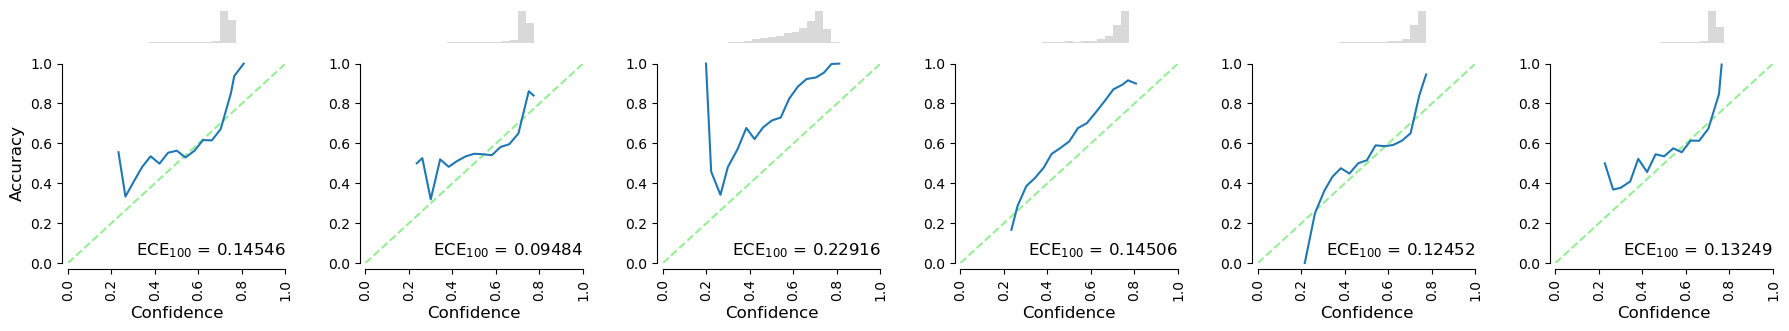

In [105]:
pre_calibration_reliability_stats = {}
n_bins = 25

_, axs = plt.subplots(ncols=k, nrows=2, figsize=(k * 3, 3.5), gridspec_kw={"height_ratios": [0.5, 3]})

for test_fold in range(k):
    preds = validation_predictions[test_fold]
    ys = validation_references[test_fold]
    
    reliability_stats = get_reliability_stats(preds, ys, n_bins=n_bins)
    _, _, _, _, ece = get_reliability_stats(preds, ys, n_bins=100)
    pre_calibration_reliability_stats[test_fold] = reliability_stats
    _, confs, accuracies, counts, _ = reliability_stats

    ax = axs[1][test_fold]
    
    ax.plot([0, 1], [0, 1], linestyle="dashed", color="lightgreen", alpha=0.95, zorder=-1)
    ax.plot(confs, accuracies, color="C0", clip_on=False)
    
    ax.text(1.0, 0.015, f"ECE$_{{100}}$ = {ece:.5f}", ha="right", va="bottom", fontsize=12, backgroundcolor="white")
    
    ax.set_xlabel("Confidence", fontsize=12)
    ax.set_ylabel(" ", fontsize=12)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="x", rotation=90)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
    ax.spines["bottom"].set_position(("outward", 4))

    ax = axs[0][test_fold]
    bins_ = [_[0] for _ in bins] + [1]
    ax.hist(bins_[:-1], bins_, weights=counts, color=[0, 0, 0, 0.15])
    ax.axis("off")

axs[1][0].set_ylabel("Accuracy", fontsize=12)
plt.tight_layout()
plt.show()

# Calibrate confidence against observed accuracy

In [142]:
calibration_models = {}

w_param = 1e-1
w_scale = 1e-2
kernel = "laplacian"

for test_fold in range(k):
    _, confs, accuracies, counts, _ = pre_calibration_reliability_stats[test_fold]

    nan_mask = (np.isnan(confs) | np.isnan(accuracies))   
    x = np.array(confs)[~nan_mask]
    y = np.array(accuracies)[~nan_mask]
    w = np.array(counts)[~nan_mask]

    x = np.array([0, *x, 1])[:, np.newaxis]
    y = np.array([0, *y, 1])
    w = (w / np.max(w)) ** w_param
    w = np.array([1, *w, 1])
    
    calibration_model = sklearn.kernel_ridge.KernelRidge(
        alpha=(1 - w) * w_scale, 
        kernel=kernel
    )
    calibration_model.fit(x, y)
    calibration_models[test_fold] = calibration_model

# Check the quality of calibration

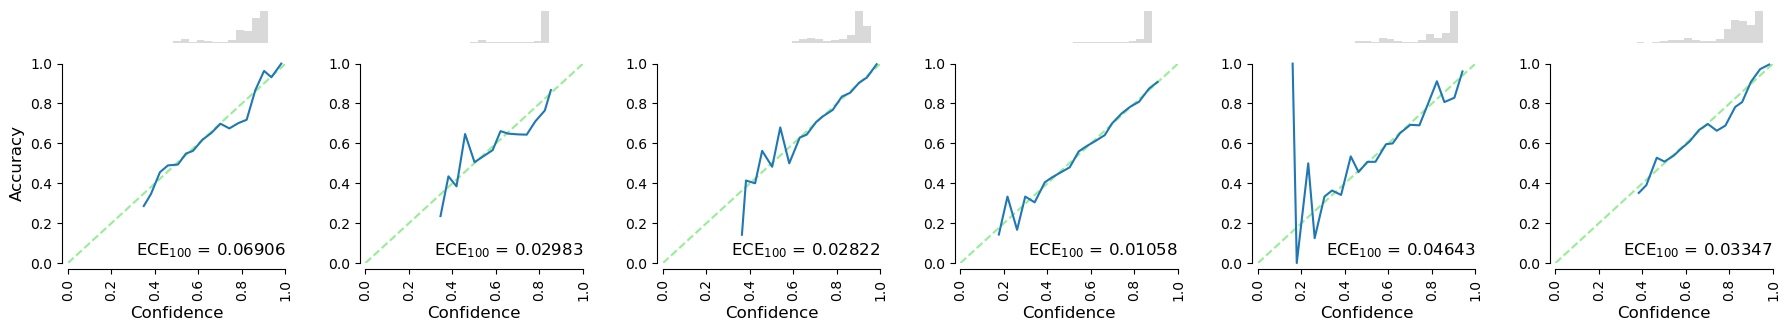

In [143]:
post_calibration_reliability_stats = {}
n_bins = 25

_, axs = plt.subplots(ncols=k, nrows=2, figsize=(k * 3, 3.5), gridspec_kw={"height_ratios": [0.5, 3]})

for test_fold in range(k):
    preds = validation_predictions[test_fold]
    ys = validation_references[test_fold]
    calibration_model = calibration_models[test_fold]
    
    reliability_stats = get_reliability_stats(preds, ys, n_bins=n_bins, calibration_model=calibration_model)
    _, _, _, _, ece = get_reliability_stats(preds, ys, n_bins=100, calibration_model=calibration_model)
    post_calibration_reliability_stats[test_fold] = reliability_stats
    _, confs, accuracies, counts, _ = reliability_stats

    ax = axs[1][test_fold]
    
    ax.plot([0, 1], [0, 1], linestyle="dashed", color="lightgreen", alpha=0.95, zorder=-1)
    ax.plot(confs, accuracies, color="C0", clip_on=False)
    
    ax.text(1.0, 0.015, f"ECE$_{{100}}$ = {ece:.5f}", ha="right", va="bottom", fontsize=12, backgroundcolor="white")
    
    ax.set_xlabel("Confidence", fontsize=12)
    ax.set_ylabel(" ", fontsize=12)
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.tick_params(axis="both", which="major", labelsize=10)
    ax.tick_params(axis="x", rotation=90)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
    ax.spines["bottom"].set_position(("outward", 4))

    ax = axs[0][test_fold]
    bins_ = [_[0] for _ in bins] + [1]
    ax.hist(bins_[:-1], bins_, weights=counts, color=[0, 0, 0, 0.15])
    ax.axis("off")

axs[1][0].set_ylabel("Accuracy", fontsize=12)
plt.tight_layout()
plt.show()

# Save models

In [144]:
for test_fold in range(k):
    calibration_model = calibration_models[test_fold]
    with open(f"confidence_calibration_models/{test_fold}_calibration_model.pickle", "wb") as file:
        pickle.dump(calibration_model, file)